In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so


# 导入工具包

In [3]:
import pandas as pd
import numpy as np
# import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gc

# 导入数据集包

In [74]:
# import riiideducation
# env = riiideducation.make_env()

In [6]:

# env = riiideducation.make_env()

# 数据目录

In [7]:
dir_path = '/kaggle/input/riiid-test-answer-prediction/'
file_train = 'train.csv'
file_questions = 'questions.csv'

# 设置读取行数

In [8]:
nrows =  100 * 10000
# nrows = None

# 读取train训练数据

In [9]:
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

# 读取问题数据

In [10]:
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                       }
                    )

# 处理prior_question_had_explanation特征

In [11]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int8   
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(1), int32(1), int64(2), int8(3), object(1)
memory usage: 35.3+ MB


In [13]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)

# 筛选数据

In [14]:
train = train[train['content_type_id']==0]

# 数据回收

In [17]:
a = train.copy()

In [18]:
del a;

In [19]:
gc.collect()

857

# 压缩数据，取最后几行

In [16]:
max_num = 100
train = train.groupby(['user_id']).tail(max_num)

# 合并数据

In [20]:
train = pd.merge(
        left=train,
        right=questions,
        how='left',
        left_on='content_id',
        right_on='question_id'
        )
# left join, right join

In [21]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part
0,0,0,115,5692,0,1,1,NaN,-1,5692,5692,5
1,1,56943,115,5716,0,2,1,37000.0,0,5716,5716,5
2,2,118363,115,128,0,0,1,55000.0,0,128,128,1
3,3,131167,115,7860,0,3,1,19000.0,0,7860,7860,1
4,4,137965,115,7922,0,4,1,11000.0,0,7922,7922,1


# 空缺数据填充0

In [22]:
train = train.fillna(0)

# 类别特征处理

In [25]:
# 【男，nv,nan,nv,nv】--> [1,0,1,0,0]
# {'男'：1，'nv'：0}
# 2 : max_len

In [26]:
class cat_deal:
    def __init__(self):
        self.max_len = 0
        self.dict_map = {}
    
    def fit(self, cat_list):
        index = 1 
        for cat_i in cat_list:
            if cat_i not in self.dict_map:
                self.dict_map[cat_i] = index
                index += 1
        self.max_len = index + 1
        
    def transform(self, cat_list):
        cat_transform_list = []
        for cat_i in cat_list:
            if cat_i in self.dict_map:
                cat_transform_list.append(self.dict_map[cat_i])
            else:
                cat_transform_list.append(0)
        return cat_transform_list

# 浮点特征处理

In [27]:
class float_deal:
    def __init__(self):
        self.max = 0
        self.min = 0
        self.max_min = 0 
        
    def fit(self, float_list):
        for float_i in float_list:
            if float_i < self.min:
                self.min = float_i
            if float_i > self.max:
                self.max = float_i
        self.max_min = self.max - self.min
        
    def transform(self, float_list):
        float_transform_list = []
        for float_i in float_list:
            if float_i < self.min:
                float_transform_list.append(0)
            elif float_i > self.max:
                float_transform_list.append(1)
            else:
                float_transform_list.append(float_i/self.max_min)
        return float_transform_list


# 对类别特征数据进行处理

In [28]:
dict_cat_class = {}
for columns in ['user_id','content_id',\
                'task_container_id','prior_question_had_explanation',\
                'bundle_id','part']:
    dict_cat_class[columns] = cat_deal()
    dict_cat_class[columns].fit(train[columns])

    train[columns] = dict_cat_class[columns].transform(train[columns])
    print(columns)

user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part


In [29]:
dict_cat_class

{'user_id': <__main__.cat_deal at 0x7f23c6bf3810>,
 'content_id': <__main__.cat_deal at 0x7f23c816f090>,
 'task_container_id': <__main__.cat_deal at 0x7f23c5f5f290>,
 'prior_question_had_explanation': <__main__.cat_deal at 0x7f23c6d61190>,
 'bundle_id': <__main__.cat_deal at 0x7f23cb16ba10>,
 'part': <__main__.cat_deal at 0x7f23c6a93fd0>}

In [31]:
dict_cat_class['part'].dict_map

{5: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7}

In [32]:
dict_cat_class['part'].max_len

9

# 浮点特征处理

In [33]:
dict_float_class = {}
for columns in ['timestamp','prior_question_elapsed_time']:
    dict_float_class[columns] = float_deal()
    dict_float_class[columns].fit(train[columns])
    
    train[columns] = dict_float_class[columns].transform(train[columns])
    print(columns)

timestamp
prior_question_elapsed_time


In [ ]:
# self.max = 0
# self.min = 0
# self.max_min = 0 

In [34]:
dict_float_class['prior_question_elapsed_time'].max

300000.0

In [35]:
dict_float_class['prior_question_elapsed_time'].min

0

In [36]:
dict_float_class['prior_question_elapsed_time'].max_min

300000.0

In [38]:
# 归一化前：80000
# 归一化后：80000 / (300000 - 0) = 0.26666666666666666

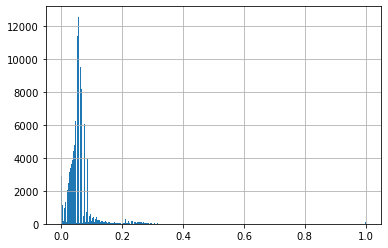

In [41]:
train['prior_question_elapsed_time'].hist(bins=1000)

In [42]:
# train['prior_question_elapsed_time_0'] = train['prior_question_elapsed_time'].map(lambda x: 1 if x==0 else 0)

# keras函数Lambda函数包装

In [43]:
def squeeze(embedding):
    embedding = tf.squeeze(embedding,axis=1)
    return embedding
def concat(embedding_list):
    embedding = tf.concat(embedding_list, axis=1)
    return embedding
def multiply(multi_x_y):
    multi_x = multi_x_y[0]
    multi_y = multi_x_y[1]
    multi_x_y = tf.multiply(multi_x, multi_y)
    return multi_x_y

# 浮点数据输入

In [44]:
input_timestamp = tf.keras.Input(shape=(1,))
input_prior_question_elapsed_time = tf.keras.Input(shape=(1,))

# 类别数据输入

In [45]:
input_user = tf.keras.Input(shape=(1,))
input_content = tf.keras.Input(shape=(1,))
input_task_container = tf.keras.Input(shape=(1,))
input_prior_question_had_explanation = tf.keras.Input(shape=(1,))
input_bundle = tf.keras.Input(shape=(1,))
input_part = tf.keras.Input(shape=(1,))

# 所有输入

In [46]:
inputs = [input_timestamp,input_prior_question_elapsed_time,\
         input_user,input_content,\
         input_task_container,input_prior_question_had_explanation,\
         input_bundle,input_part]

# 类别特征embeeding转换

In [47]:
tf.keras.layers.Embedding?

In [48]:
embedding_user = tf.keras.layers.Embedding(dict_cat_class['user_id'].max_len,
                                           1, input_length=1)(input_user)
embedding_user = tf.keras.layers.Lambda(squeeze)(embedding_user)

embedding_content = tf.keras.layers.Embedding(dict_cat_class['content_id'].max_len,
                                              1, input_length=1)(input_content)
embedding_content = tf.keras.layers.Lambda(squeeze)(embedding_content)

embedding_task_container = tf.keras.layers.Embedding(dict_cat_class['task_container_id'].max_len,
                                                     1, input_length=1)(input_task_container)
embedding_task_container = tf.keras.layers.Lambda(squeeze)(embedding_task_container)

embedding_prior_question_had_explanation = tf.keras.layers.Embedding(dict_cat_class['prior_question_had_explanation'].max_len, 
                                                                     1, input_length=1)(input_prior_question_had_explanation)
embedding_prior_question_had_explanation = tf.keras.layers.Lambda(squeeze)(embedding_prior_question_had_explanation)

embedding_bundle = tf.keras.layers.Embedding(dict_cat_class['bundle_id'].max_len,
                                             1, input_length=1)(input_bundle)
embedding_bundle = tf.keras.layers.Lambda(squeeze)(embedding_bundle)

embedding_part = tf.keras.layers.Embedding(dict_cat_class['part'].max_len,
                                           1, input_length=1)(input_part)
embedding_part = tf.keras.layers.Lambda(squeeze)(embedding_part)

# 合并类别特征对应的embeeding特征和浮点特征

In [49]:
embedding_all = [input_timestamp,input_prior_question_elapsed_time,\
                embedding_user, embedding_content, embedding_task_container,\
                embedding_prior_question_had_explanation, embedding_bundle, embedding_part]

lr_all = embedding_all + [input_timestamp,input_prior_question_elapsed_time]

In [53]:
embedding_all

[<tf.Tensor 'input_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda/Squeeze:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda_1/Squeeze:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda_2/Squeeze:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda_3/Squeeze:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda_4/Squeeze:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda_5/Squeeze:0' shape=(None, 1) dtype=float32>]

# logits regression线性层

In [54]:
lr_layer

<tf.Tensor 'lambda_6/concat:0' shape=(None, 10) dtype=float32>

In [50]:
lr_layer = tf.keras.layers.Lambda(concat)(lr_all) 
# lr_layer = tf.keras.layers.Dense(1, activation=tf.nn.relu/tf.nn.tanh)(lr_layer) 
logit = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(lr_layer)

In [60]:
# y = sigmoid(wx)
# x * sigmoid(x) 激活：rule

# 模型输入和输出

In [56]:
model = tf.keras.models.Model(inputs=inputs, outputs=logit)

# 编译模型

In [57]:
# ylogy + (1-y)log(1-y)
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_crossentropy'])

# 设置学习率自动0.1减少函数

In [58]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            verbose=0,
                            mode='min',
                            factor=0.1,
                            patience=6)

# 设置早停函数

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               verbose=0,
                               mode='min',
                               patience=10)

# 设置保存点

In [61]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'fold.h5',
                             monitor='val_loss',
                             verbose=0,
                             mode='min',
                             save_best_only=True)

In [75]:
model.summary()

AttributeError: 'Functional' object has no attribute 'summarymary'

# 验证数据获取、剩下的数据为训练数据

In [62]:
valid = pd.DataFrame()
for i in range(6):
    
    # 获取验证标签数据
    last_records = train.drop_duplicates('user_id', keep='last')
    
    # 获取验证标签以前的数据
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    train['filter_row'] = train['user_id'].map(map__last_records__user_row)
    train = train[train['row_id']<train['filter_row']]

    # 特征加入验证集
    valid = valid.append(last_records)
    print(len(valid))

3824
7646
11466
15285
19104
22923


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# 数据特征切分以及删除train、valid，减少内存

In [63]:
# train['timestamp']

# 训练模型特征

In [64]:
features_columns = ['timestamp','prior_question_elapsed_time',\
                    'user_id','content_id',\
                    'task_container_id','prior_question_had_explanation',\
                    'bundle_id','part']

# 训练和测试集数据切分

In [65]:
X_valid, y_valid = [valid[columns].values for columns in features_columns], valid['answered_correctly'].values
# del valid

X_train, y_train = [train[columns].values for columns in features_columns], train['answered_correctly'].values
# del train

In [67]:
X_train[0].shape

(191436,)

In [68]:
X_valid[0].shape

(22923,)

# 训练模型

In [69]:
model.fit(X_train, y_train,
          epochs=10,
          batch_size=512 * 500 * 2,
          verbose=1,
          shuffle=True,
          validation_data=(X_valid, y_valid),
          callbacks=[plateau, early_stopping, checkpoint])

Epoch 1/10
1/1 [==============================] - 0s 296ms/step - loss: 0.7024 - binary_crossentropy: 0.7024 - val_loss: 0.6982 - val_binary_crossentropy: 0.6982
Epoch 2/10
1/1 [==============================] - 0s 64ms/step - loss: 0.7019 - binary_crossentropy: 0.7019 - val_loss: 0.6979 - val_binary_crossentropy: 0.6979
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 0.7014 - binary_crossentropy: 0.7014 - val_loss: 0.6976 - val_binary_crossentropy: 0.6976
Epoch 4/10
1/1 [==============================] - 0s 64ms/step - loss: 0.7010 - binary_crossentropy: 0.7010 - val_loss: 0.6973 - val_binary_crossentropy: 0.6973
Epoch 5/10
1/1 [==============================] - 0s 64ms/step - loss: 0.7005 - binary_crossentropy: 0.7005 - val_loss: 0.6970 - val_binary_crossentropy: 0.6970
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.7000 - binary_crossentropy: 0.7000 - val_loss: 0.6967 - val_binary_crossentropy: 0.6967
Epoch 7/10
1/1 [=================

# 测试集验证结果

In [70]:
y_valid_proba = model.predict(X_valid, verbose=0, batch_size=512)
auc = roc_auc_score(y_valid, y_valid_proba)
print(auc)

0.5132494126811524


# 继续训练和验证

In [71]:
model.fit(X_train, y_train,
          epochs=1,
          batch_size=512 * 500 * 2,
          verbose=1,
          shuffle=True,
          validation_data=(X_valid, y_valid),
          callbacks=[plateau, early_stopping, checkpoint])

y_valid_proba = model.predict(X_valid, verbose=0, batch_size=512)
auc = roc_auc_score(y_valid, y_valid_proba)
print(auc)

1/1 [==============================] - 0s 108ms/step - loss: 0.6977 - binary_crossentropy: 0.6977 - val_loss: 0.6952 - val_binary_crossentropy: 0.6952
0.5168912015196118


# 测试集环境

In [72]:
# iter_test = env.iter_test()

In [73]:
# for (test_df, sample_prediction_df) in iter_test:

#     # 处理特征
#     test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)

#     # 合并样本
#     test_df = pd.merge(
#         left=test_df,
#         right=questions,
#         how='left',
#         left_on='content_id',
#         right_on='question_id'
#         )

#     test_df = test_df.fillna(0)


#     for columns in ['user_id','content_id',\
#                     'task_container_id','prior_question_had_explanation',\
#                     'bundle_id','part']:

#         test_df[columns] = dict_cat_class[columns].transform(test_df[columns])
#         print(columns)


#     for columns in ['timestamp','prior_question_elapsed_time']:
      
#         test_df[columns] = dict_float_class[columns].transform(test_df[columns])
#         print(columns)

#     X_test = [test_df[columns].values for columns in features_columns]

#     test_df['answered_correctly'] =  model.predict(X_test, verbose=0, batch_size=512)
#     env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part
timestamp
prior_question_elapsed_time
user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part
timestamp
prior_question_elapsed_time
user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part
timestamp
prior_question_elapsed_time
user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part
timestamp
prior_question_elapsed_time
